In [1]:
import numpy as np
from floquet_simulations.plot_functions import PlotParams
PlotParams(fontsize=10)
from floquet_simulations.hamiltonians import GetEvalsAndEvecsGen
from scipy.integrate import solve_ivp
from floquet_simulations.hamiltonians import RoundComplex
from floquet_simulations.plot_functions import PlotAbsRealImagHamiltonian
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import jv
from pathlib import Path
import pandas as pd
import math
from numpy import sin, cos, pi



def square_2D_edges(rows, columns):
    H0 = np.zeros((rows*columns,rows*columns))
    # 
    links = []
    for y in range(rows):
        for x in range(columns-1):
            links.append((x + y*columns, x+1 + y* columns))
    for y in range(rows-1):
        for x in range(columns):
            links.append((x + columns*y, x+columns + columns*y))
    return(links)



def H0_2D(rows, columns):
    H0 = np.zeros((rows*columns,rows*columns))
    links = square_2D_edges(rows, columns)
    for link in links:
        H0[link[0], link[1]] = -1
        H0[link[1], link[0]] = -1
    return H0



def HT(H0, funcs, sites, t):
    for func, site in zip(funcs, sites):
        H0[site-1,site-1] = func(t)
    return H0



def FT(t, psi, H0, funcs, sites):
    H = HT(H0, funcs, sites, t)
    return -1j*np.dot(H, psi)



def SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0):
    rtol=1e-11
    # points to calculate the matter wave at
    t_eval = np.linspace(tspan[0], tspan[1], n_timesteps+1, endpoint=True)
    sol = solve_ivp(lambda t,psi: FT(t, psi, H0, funcs, sites), 
            t_span=tspan, y0=psi0, rtol=rtol, 
            atol=rtol, t_eval=t_eval,
            method='RK45')
    sol=sol.y
    return sol



def CreateHF(H0, funcs, sites, T, num_sites, t0=0, hermitian_accuracy_dp=7): 
    """
    t0 is fraction of T
    """
    #sanity check
    assert(len(H0) == num_sites)
    tspan = (t0*T,T+t0*T)
    UT = np.zeros([num_sites, num_sites], dtype=np.complex_)
    n_timesteps = 100
    for A_site_start in range(num_sites):
        psi0 = np.zeros(num_sites, dtype=np.complex_); psi0[A_site_start] = 1
        sol = SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0)
        UT[:,A_site_start]=sol[:,-1] 
    # evals_U, evecs = eig(UT)
    evals_U, evecs = GetEvalsAndEvecsGen(UT) #evals can be imaginary
    evals_H = 1j / T *np.log(evals_U)
    HF = np.zeros([num_sites,num_sites], dtype=np.complex_)
    for i in range(num_sites):
        term = evals_H[i]*np.outer(evecs[:,i], np.conj(evecs[:,i]))
        HF = HF+term
    HF = RoundComplex(HF, hermitian_accuracy_dp)
    # assert(np.all(0 == (HFr - np.conj(HFr.T))))
    return UT, HF
    # if np.all(0 == (HF - np.conj(HF.T))):
    #     return UT, HF
    # else:
    #     return np.nan, np.nan

def make_bewteen_0_2(x):
    if x <0:
        return x+2
    elif x > 2:
        return x - 2
    else:
        return x



def get_xi_same_a(A, varphii, varphij):
    Aij = A*np.abs(2*sin((varphij - varphii)/2))
    if varphij > varphii:
        # ie Aij is naturally positive
        return Aij, (varphii + varphij)/2 -pi/2
    elif varphij < varphii:
        return Aij,  (varphii + varphij)/2 + pi/2
    else:
        return 0, 0
    

def get_A_and_xi_ij(Ai, Aj, phii, phij, same_A = False):
# note we expect  Aj term to be negative ie we are finding the difference between Ai cos(omega t + phii) - Aj cos (omega t + phij)!!!!!
# calculates the the difference, not the sum
    if same_A:
        #different algorithm
        if  (np.round(phii/pi,7) == np.round(phij/pi,7)) or (np.round(phii/pi,7)== np.round( phij/pi + 2,7)) or (np.round(phii/pi + 2,7)== np.round( phij/pi,7)):
            return 0,0
    # elif (np.round(Ai,7) ==np.round(Aj,7)):
        else:

            return 2*sin((phii - phij)/2),  (phii + phij)/2 - pi/2
    else:

        if (np.round(Ai,7) ==np.round(Aj,7)) and ((np.round(phii/pi,7) == np.round(phij/pi,7)) or (np.round(phii/pi,7)== np.round( phij/pi + 2,7)) or (np.round(phii/pi + 2,7)== np.round( phij/pi,7))):
            return 0,0

        else:
            Aij =  np.sqrt(Aj**2 + Ai**2 - 2*Ai*Aj*np.cos(phii - phij))

            cos_result = (-Aj * np.cos(phij) + Ai*np.cos(phii))/(Aij)
            sin_result = (-Aj*np.sin(phij) + Ai*np.sin(phii))/(Aij)
            cos_args = np.round(np.array( [np.arccos(cos_result)/np.pi, 2 - np.arccos(cos_result)/np.pi])  , 5)
            sin_args = np.round(np.array([i + 2 if i<0 else i for i in [np.arcsin(sin_result)/np.pi, 1 - np.arcsin(sin_result)/np.pi] ]), 5)

            return Aij, np.intersect1d(cos_args, sin_args)[0]*np.pi



def Vt(m,n, kappa, omega, t):
    phi0 = 0
    fr = np.cos(m*np.pi/2 - np.pi/4)
    fb = np.cos(m*np.pi/2 + np.pi/4)
    gr = phi0 - n*np.pi/2
    gb = n*np.pi/2 - phi0 - np.pi/2
    return kappa*(fr*np.cos(omega*t + gr) + fb*np.cos(omega*t + gb)) #+ Delta/2*(-1)**m + delta/2*((-1)**m + (-1)**n)



## gradiented flux

In [2]:

    # omega = 10
omega = 25
g_const = 0.1*pi #g
h_const = 0.5*pi #h
L_x = 20
L_y = 4
N = L_x*L_y
AA = 5
T = 2*np.pi/omega
m_site, n_site = np.meshgrid(np.arange(L_x), np.arange(L_y))

tri_nums = np.array([n*(n+1)/2 for n in range(L_x)])
A_j= np.array([[AA]*(L_x) for row in range(L_y)])
varphi_j = np.array([[tri_nums[i]*g_const + j*h_const for i in range(L_x)] for j in range(L_y)])
nus = np.array([[0 + j*omega for i in range(L_x)] for j in range(L_y)] )
print(varphi_j / np.pi)
print(nus)
# print(A_j)

[[ 0.   0.1  0.3  0.6  1.   1.5  2.1  2.8  3.6  4.5  5.5  6.6  7.8  9.1
  10.5 12.  13.6 15.3 17.1 19. ]
 [ 0.5  0.6  0.8  1.1  1.5  2.   2.6  3.3  4.1  5.   6.   7.1  8.3  9.6
  11.  12.5 14.1 15.8 17.6 19.5]
 [ 1.   1.1  1.3  1.6  2.   2.5  3.1  3.8  4.6  5.5  6.5  7.6  8.8 10.1
  11.5 13.  14.6 16.3 18.1 20. ]
 [ 1.5  1.6  1.8  2.1  2.5  3.   3.6  4.3  5.1  6.   7.   8.1  9.3 10.6
  12.  13.5 15.1 16.8 18.6 20.5]]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
 [50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50]
 [75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75 75]]


In [3]:
sites = np.arange(1,L_x*L_y + 1,1)
## get drives on each site
funcs = [lambda t, A=A, varphi=varphi, nu=nu: A*np.cos(omega*t + varphi) + nu for (A, varphi, nu) in zip(A_j.flatten(), varphi_j.flatten(), nus.flatten())]
_, HF = CreateHF(H0_2D(L_y,L_x), funcs, sites, T, num_sites=L_x*L_y, t0=0, hermitian_accuracy_dp=7)


In [ ]:

A_j = A_j.flatten()
varphi_j = varphi_j.flatten()
nus = nus.flatten()
# for links 1-10
Bs = np.zeros((N, N))
xis = np.zeros((N, N))
HF_theory = np.zeros((N, N), dtype=np.complex128)
#do horizontal links
for ny in range(L_y):
        for nx in range(L_x-1):        
                jj = nx + L_x*ny
                ii = nx+L_x*ny + 1

                nu_ij = int(nus[ii] - nus[jj])/omega
                
                B_ij, xi_ij= get_A_and_xi_ij(A_j[ii], A_j[jj], varphi_j[ii], varphi_j[jj], same_A = True)
                t_ij = jv(nu_ij, B_ij/omega)*np.exp((-1)*nu_ij*1j*xi_ij)

                print(ii,jj, nu_ij, f"{np.abs(t_ij):.4f}", f"{np.angle(t_ij)/pi:.4f}")

                Bs[ii, jj] = B_ij
                xis[ii, jj] = xi_ij

                HF_theory[ii,jj] = t_ij
                HF_theory[jj, ii] = np.conj(t_ij)

        #do vertical links
for ny in range(L_y-1):
        for nx in range(L_x):
                jj = nx + L_x*ny
                ii = nx+L_x*ny + L_x

                nu_ij = int(nus[ii] - nus[jj])/omega


                B_ij, xi_ij= get_A_and_xi_ij(A_j[ii], A_j[jj], varphi_j[ii], varphi_j[jj], same_A = True)
                t_ij = jv(nu_ij, B_ij/omega)*np.exp((-1)*nu_ij*1j*xi_ij)

                print(ii,jj, nu_ij, f"{np.abs(t_ij):.4f}", f"{np.angle(t_ij)/pi:.4f}")

                Bs[ii,jj] = B_ij
                xis[ii, jj] = xi_ij
                HF_theory[ii,jj] = t_ij
                HF_theory[jj, ii] = np.conj(t_ij)
        # 

tunnelling_indices = [(1,2), (2,3), (3,4), (1,5), (2,6), (3,7), (4,8), (5,6), (6,7), (7,8)
                      ,(9,10), (10,11),(11,12)
                #       ,(9,13),(10,14),(11,15),(12,16),(13,14),(14,15),(15,16)
                      ]
                            
plaquettess = []
plaquette_sides =  [(0,0), (L_x,1), (L_x - 1, L_x + 1), (-1,L_x)]
# plaquettess = [[(kk+1+i, kk+j) for (i,j) in plaquette_sides] for kk in np.array([[jj*L_x+ ii for ii in range(L_x-1)] for jj in range(L_y - 1)]).flatten()]
for p_num in range(1,L_x ):
        plaquettess.append([(p_num+i, p_num - 1+j) for (i,j) in plaquette_sides])


# with pd.option_context('display.max_rows', None,
#                     'display.max_columns', 10,
#                     'display.precision', 2,
#                     ):
# #         print(tunnellings_abs)
#         print(pd.DataFrame(np.array([np.angle(math.prod([HF[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess]).reshape((1,L_x - 1))))
#         print(pd.DataFrame(np.array([np.angle(math.prod([HF_theory[i, j] for (i,j) in plaquette]))/np.pi for plaquette in plaquettess]).reshape((1,L_x - 1))))


## plaquette flux as arrays to plot

In [4]:
plaquette_sides =  [(0,1), (1,1 + L_x), (1+ L_x, L_x ), (L_x,0)]
plaquette_vals = np.zeros((L_x - 1, L_y - 1))
for my in range(L_y - 1):
        for nx in range(L_x - 1):
                jj = nx + L_x*my
                plaquette_sides_jj = [(jj+i, jj+j) for (i,j) in plaquette_sides]
                plaquette_vals[nx, my] = np.angle(math.prod([HF[i, j] for (i,j) in plaquette_sides_jj]))/np.pi
# set to between 0 and 2 pi
plaquette_vals = np.where(plaquette_vals< 0, plaquette_vals + 2, plaquette_vals)

### For 2D figure

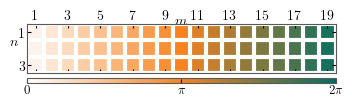

In [5]:
colourbar_pad=0.1
colourbar_size_percentage=5
cm_unit = 1/2.54
figsize = (L_x, L_y)/np.max([L_x, L_y])*10.1

data_cmap_lims = (0,2); colourbar_cmap_lims=(0,2); colourbar_ticks = np.arange(0,2.1,1)
norm = mpl.colors.Normalize(vmin=data_cmap_lims[0], vmax=data_cmap_lims[1])
cmap = LinearSegmentedColormap.from_list('custom hamiltonians', [ "#FFFFFF",  '#F78320', '#006F63'], N=256)

cm_unit = 1/2.54
fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
pcm = ax.matshow(plaquette_vals.T, interpolation='none', cmap=cmap,  norm=norm)
# ax.set_title(label)

ax.tick_params(axis="y", left=True, right=True, labelleft=True, 
        labelright=False, direction = "in", length = 3, pad=1)  

ax.yaxis.set_label_coords(-0.043,0)
ax.set_ylabel('$n$', rotation=0)
ax.set_yticks(np.arange(0,L_y-1,2))
ax.set_yticklabels([f"${i}$" for i in np.arange(1,L_y,2)], font = "stix")
ax.set_xlabel('$m$', rotation=0)
ax.xaxis.set_label_coords(0.5,1.2)
ax.set_xticks(np.arange(0,L_x-1,2))
ax.set_xticklabels([f"${i}$" for i in np.arange(1,L_x,2)], font = "stix")

ax.spines[:].set_visible(True)
ax.set_xticks(np.arange(plaquette_vals.shape[0]+1)-.5, minor=True)
ax.set_yticks(np.arange(plaquette_vals.shape[1]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False, top=False, right=False)

ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, 
        labeltop=True, direction = "in", length = 3, pad=1)
  
ax.set_axisbelow(True)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(
    ax,
    width="100%",  # width: 5% of parent_bbox width
    height="10%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(0, -0.2, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axins, ticks=colourbar_ticks, orientation="horizontal", format=mpl.ticker.FixedFormatter([r'$0$', r'$\pi$', r"$2\pi$"]), ticklocation="bottom")
cbar.ax.tick_params(labelsize=9, pad=1)


# fig.savefig(Path().absolute().parent.parent.parent/"figures"/"local_mod_paper"/"grad_mag_field_flux_5x20_v2.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()

### For 1D Figure

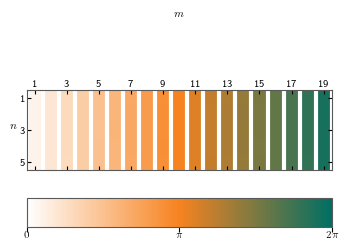

In [7]:
colourbar_pad=0.1
colourbar_size_percentage=5
cm_unit = 1/2.54
figsize = (L_x, L_y)/np.max([L_x, L_y])*10

data_cmap_lims = (0,2); colourbar_cmap_lims=(0,2); colourbar_ticks = np.arange(0,2.1,1)
norm = mpl.colors.Normalize(vmin=data_cmap_lims[0], vmax=data_cmap_lims[1])
cmap = LinearSegmentedColormap.from_list('custom hamiltonians', [ "#FFFFFF",  '#F78320', '#006F63'], N=256)

cm_unit = 1/2.54
fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
pcm = ax.matshow(plaquette_vals.T, interpolation='none', cmap=cmap,  norm=norm)
# ax.set_title(label)

ax.tick_params(axis="y", left=True, right=True, labelleft=True, 
        labelright=False, direction = "in", length = 3, pad=1)  

ax.yaxis.set_label_coords(-0.043,0)
ax.set_ylabel('$n$', rotation=0)
ax.set_yticks(np.arange(0,L_y-1,2))
ax.set_yticklabels(np.arange(1,L_y,2))
ax.set_xlabel('$m$', rotation=0)
ax.xaxis.set_label_coords(0.5,2)
ax.set_xticks(np.arange(0,L_x-1,2))
ax.set_xticklabels(np.arange(1,L_x,2))

ax.spines[:].set_visible(True)
ax.set_xticks(np.arange(plaquette_vals.shape[0]+1)-.5, minor=True)
# ax.set_yticks(np.arange(plaquette_vals.shape[1]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False, top=False, right=False)

ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, 
        labeltop=True, direction = "in", length = 3, pad=1)
  
ax.set_axisbelow(True)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(
    ax,
    width="100%",  # width: 5% of parent_bbox width
    height="35%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(0, -0.7, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axins, ticks=colourbar_ticks, orientation="horizontal", format=mpl.ticker.FixedFormatter([r'$0$', r'$\pi$', r"$2\pi$"]), ticklocation="bottom")
cbar.ax.tick_params(labelsize=7, pad=0)


# fig.savefig(Path().absolute().parent.parent.parent/"figures"/"local_mod_paper"/"grad_mag_field_flux.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()

# plot HF

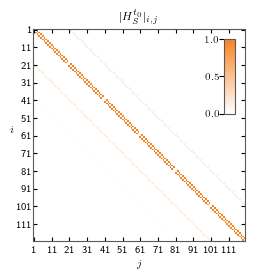

In [8]:
colourbar_pad=0.1
colourbar_size_percentage=5
cm_unit = 1/2.54
figsize = (7, 7)

data_cmap_lims = (0, 1); colourbar_cmap_lims=(0,1); colourbar_ticks = np.arange(0,1.1,0.5)
norm = mpl.colors.Normalize(vmin=data_cmap_lims[0], vmax=data_cmap_lims[1])
cmap = LinearSegmentedColormap.from_list('custom hamiltonians', [ "#FFFFFF",  '#F78320'], N=256)

cm_unit = 1/2.54
fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
pcm = ax.matshow(np.abs(HF), interpolation='none', cmap=cmap,  norm=norm)
# ax.set_title(label)
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, 
        labeltop=False, direction = "in", length = 3)  
ax.tick_params(axis="y", left=True, right=True, labelleft=True, 
        labelright=False, direction = "in", length = 3, pad=1)  


ax.yaxis.set_label_coords(-0.1,0)
ax.set_ylabel('$i$', rotation=0)
ax.set_xlabel('$j$', rotation=0)

ax.set_yticks(np.arange(0,L_x*L_y,10))
ax.set_yticklabels(np.arange(1, L_x*L_y + 1,10))
ax.set_xticks(np.arange(0,L_x *L_y, 10))
ax.set_xticklabels(np.arange(1,L_x* L_y + 1,10))
ax.set_title(r"$|H_S^{t_0}|_{i,j}$")
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(
    ax,
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(0.9, 0.6, 1, 0.7),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axins, ticks=colourbar_ticks, ticklocation="left")
cbar.ax.tick_params(labelsize=7, pad=0)

fig.savefig(Path().absolute().parent.parent.parent/"figures"/"local_mod_paper"/"grad_mag_field_abs_ham.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()

In [9]:
print(second_row_x_tun_list)
print(top_row_x_tun_list)
print(len(bottom_horizontal_tunnellings), len(top_horizontal_tunnellings), len(vertical_tunnellings))

NameError: name 'second_row_x_tun_list' is not defined

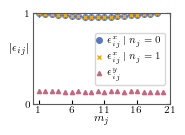

0.040638949790263945


In [ ]:
PlotParams(fontsize=8)
params = {'legend.fontsize': 7,
          'legend.handlelength': 0}
mpl.rcParams.update(params)

figsize = (4.5,3)
fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))
# row_tun_i_list = [jj for jj in range(L_x*L_y - 1) if (jj+1)%L_x!=0 ]
top_row_x_tun_list = list(range(L_x - 1))
second_row_x_tun_list = list(range(L_x, 2*L_x - 1))


top_horizontal_tunnellings = np.array([np.abs(HF[ii, ii+1]) for ii in top_row_x_tun_list])
bottom_horizontal_tunnellings = np.array([np.abs(HF[ii, ii+1]) for ii in second_row_x_tun_list])
vertical_tunnellings = np.array([np.abs(HF[ii, ii+L_x]) for ii in range(L_x )])
ax.plot(range((L_x-1)), top_horizontal_tunnellings,    'o', ms=4, label=r"$n_i = n_j = 1$", color = "#5778C7")
ax.plot(range((L_x-1)), bottom_horizontal_tunnellings, 'x', ms=3, label=r"$n_i = n_j = 2$", color = "#F5AB00")
ax.plot(list(range(L_x)), vertical_tunnellings, '^', ms = 3, label=r"$\epsilon_{ij}^y$", color = "#C96480")

ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, 
        labeltop=False, direction = "in", length = 3, pad=1)  
ax.tick_params(axis="y", left=True, right=True, labelleft=True, 
        labelright=False, direction = "in", length = 3, pad=1) 


ax.set_ylabel(r"$| \epsilon_{ij}|$", rotation=0)
ax.yaxis.set_label_coords(-0.09,0.54)
ax.set_yticks(np.arange(0,1.1,1))
ax.set_xlabel(r"$m_j$")
ax.set_xticks(np.arange(0,21,5))
ax.set_xticklabels(np.arange(1,22,5))
ax.xaxis.set_label_coords(0.5,-0.12)       

ax.set_ylim([0,1])
ax.legend(loc="center right")
fig.savefig(Path().absolute().parent.parent.parent/"figures"/"local_mod_paper"/"flux_ladder_abs_vals.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()
print(np.max(np.concatenate([top_horizontal_tunnellings, bottom_horizontal_tunnellings])) - np.min(np.concatenate([top_horizontal_tunnellings, bottom_horizontal_tunnellings])))

In [ ]:
a = np.array([1,2,3])
np.concatenate([a,a])

array([1, 2, 3, 1, 2, 3])

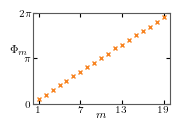

In [ ]:
figsize = (4.5,3)


fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))
ax.plot(list(range((L_x-1))),plaquette_vals, 'x', ms=3, color=  '#F78320')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, 
        labeltop=False, direction = "in", length = 3, pad=1)  
ax.tick_params(axis="y", left=True, right=True, labelleft=True, 
        labelright=False, direction = "in", length = 3, pad=1)  
ax.set_ylabel(r"$\Phi_{m}$", rotation=0)
ax.yaxis.set_label_coords(-0.1,0.54)
ax.set_yticks(np.arange(0,2.1,1))
ax.set_yticklabels([r"$0$", r"$\pi$", r"$2\pi$"])
ax.set_xlabel(r"$m$")
ax.set_xticks(np.arange(0,20,6))
ax.set_xticklabels(np.arange(1,21,6))
ax.xaxis.set_label_coords(0.5,-0.06)
ax.set_ylim([0,2])
fig.savefig(Path().absolute().parent.parent.parent/"figures"/"local_mod_paper"/"flux_ladder_flux_vals.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()

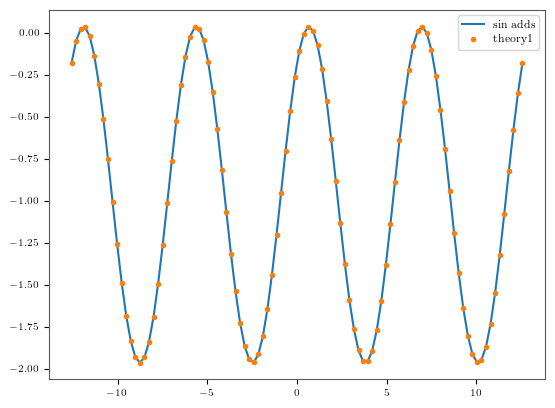

In [ ]:
from numpy import pi, sin, cos
phij = 0.3*pi
phii = np.linspace(-4*pi,4*pi, 100)
Aij = 2*sin((phii - phij)/2)
xi_theory1 =  ((phii + phij)/2 - pi/2)%(2*pi) 
xi_theory2 = ((phii + phij)/2 + pi/2)%(2*pi)

plt.plot(phii, sin(0.9 + phii) - sin(0.9+ phij),  label="sin adds")
plt.plot(phii, -Aij*sin(0.9+ xi_theory1), '.', label = "theory1")
# plt.plot(phii, Aij*sin(xi_theory2), '.', label = "theory2")
plt.legend()
plt.show()

SyntaxError: invalid syntax (181085120.py, line 3)